In [61]:
import wikipedia
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import nltk
import spacy
from collections import Counter
from nltk.data import find
from nltk.tokenize.punkt import PunktSentenceTokenizer
import certifi
import ssl
import string

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

os.environ['SSL_CERT_FILE'] = certifi.where()

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
punctuation = set(string.punctuation)

wikipedia.set_lang("ru")
stop_words = set(stopwords.words('russian'))

In [2]:
all_articles = []
all_titles = []
topics = ['Образование', 'Космические исследование', 'Экономика']
num_articles = 15
for topic in topics:
    print(f"Downloading articles about: {topic}")
    articles = []
    titles = []

    search_results = wikipedia.search(topic, results=num_articles*2)

    count = 0
    for title in search_results:
        if count >= num_articles:
            break

        try:
            page = wikipedia.page(title)
            articles.append(page.content)
            titles.append(title)
            count += 1
            print(f"Downloaded article: {title}")
        except Exception as e:
            print(f"Error downloading article '{title}': {e}")

    all_articles.append(articles)
    all_titles.append(titles)

Downloaded article: Образование
Downloaded article: Муниципальное образование
Downloaded article: Образование в СССР
Downloaded article: Общее образование
Downloaded article: Яндекс Образование


/Users/thematrix/Documents/МГТУ/ЦОСИ/labs&practise/.venv/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/thematrix/Documents/МГТУ/ЦОСИ/labs&practise/.venv/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Error downloading article 'Образование (значения)': "Образование (значения)" may refer to: 
Значения в Викисловаре
Тексты в Викитеке
Образование
Начальное образование
Начальное образование
Среднее образование
Высшее образование
Образование
Образование
Образование
Образование
Образование
Муниципальное образование
Формация
Downloaded article: Семейное образование
Downloaded article: Образование в Беларуси
Downloaded article: Квалификация (образование)
Downloaded article: Образование в США
Downloaded article: Образование в России
Downloaded article: Уровни образования
Downloaded article: Высшее образование
Downloaded article: Среднее образование
Downloaded article: Женское образование
Downloaded article: Образование в Казахстане
Downloaded article: Освоение космоса
Downloaded article: Исследование Венеры
Downloaded article: НАСА
Downloaded article: Институт космических исследований РАН
Downloaded article: Роскосмос
Downloaded article: Национальный центр космических исследований
Downloaded

In [10]:
articles = [article for sublist in all_articles for article in sublist]
titles = [title for sublist in all_titles for title in sublist]

In [62]:
nlp = spacy.load('ru_core_news_sm')

def preprocess_text(text):
    # text = nlp(text.lower())
    # lemmatized_words = [token.lemma_ for token in text if token.text not in punctuation and token.text not in stop_words]
    # return " ".join(lemmatized_words)
    stemmer = SnowballStemmer('russian')
    tokens = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_words)

vectorizer = TfidfVectorizer(preprocessor=preprocess_text, max_features=10000)
X = vectorizer.fit_transform(articles)
feature_names = vectorizer.get_feature_names_out()
print(vectorizer.get_feature_names_out())
print(X.shape)
print(feature_names)

['000' '01' '01м' ... '太阳' '學院' '高等學校']
(45, 10000)
['000' '01' '01м' ... '太阳' '學院' '高等學校']


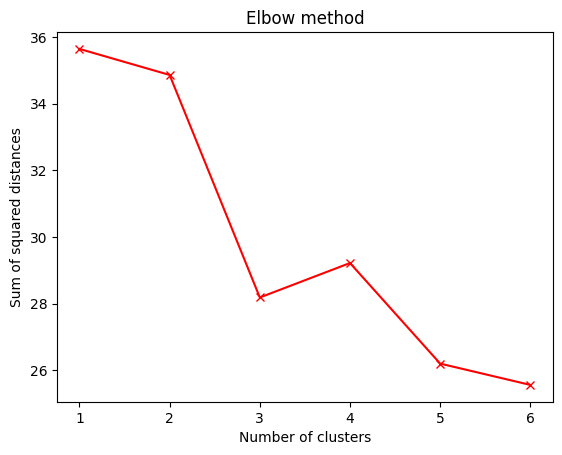

In [63]:
sum_of_squared_distances = []
K = range(1, 7)
for k in K:
    km = KMeans(n_clusters=k, max_iter=4000)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'rx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method')
plt.show()


In [64]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1500)
model.fit(X)
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(titles,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                                                title  cluster
22         Орбитальная спутниковая группировка России        0
29                         Космическая программа СССР        0
28                                  Исследование Луны        0
27                  Международная космическая станция        0
4                                  Яндекс Образование        0
24     Индийская организация космических исследований        0
23                                Космонавтика России        0
21                                  Космическая гонка        0
20        Национальный центр космических исследований        0
19                                          Роскосмос        0
18              Институт космических исследований РАН        0
17                                               НАСА        0
15                                   Освоение космоса        0
14                           Образование в Казахстане        1
0                                         Образование  

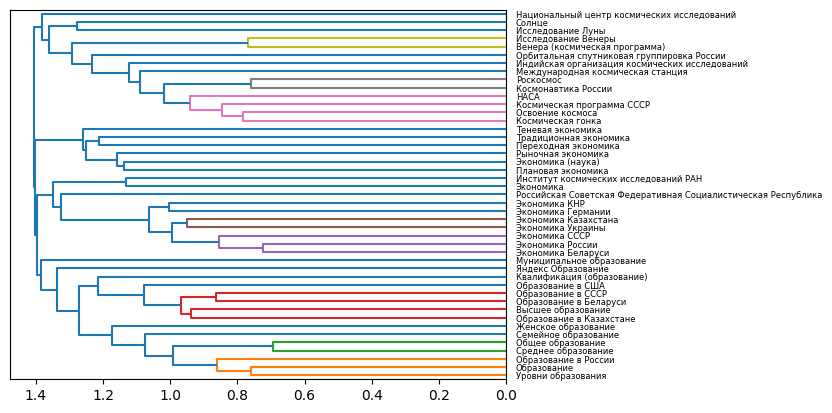

In [71]:
mergins = linkage(X.toarray(), method='complete')
dendrogram(mergins,
           labels=titles,
           leaf_font_size=6,
           orientation='left',
           count_sort='descending',
           show_leaf_counts=True
           )

plt.show()

In [66]:
from sklearn.metrics import silhouette_score

for eps in np.arange(0.1, 10, 0.05):
    for min_samples in range(3, 15):
        db = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine').fit(X)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters == 3:
            print(f"eps={eps:.2f}, min_samples={min_samples}, clusters={n_clusters}")
            if n_clusters > 1:
                score = silhouette_score(X, labels)
                print(f"Silhouette score: {score:.4f}")

eps=0.35, min_samples=3, clusters=3
Silhouette score: -0.0044
eps=0.35, min_samples=4, clusters=3
Silhouette score: -0.0044
eps=0.40, min_samples=3, clusters=3
Silhouette score: 0.0551
eps=0.40, min_samples=4, clusters=3
Silhouette score: 0.0439
eps=0.40, min_samples=5, clusters=3
Silhouette score: 0.0380
eps=0.45, min_samples=3, clusters=3
Silhouette score: 0.0879
eps=0.45, min_samples=4, clusters=3
Silhouette score: 0.0879
eps=0.45, min_samples=5, clusters=3
Silhouette score: 0.0820
eps=0.45, min_samples=6, clusters=3
Silhouette score: 0.0820
eps=0.45, min_samples=7, clusters=3
Silhouette score: 0.0735


In [67]:
dbscan = DBSCAN(eps=0.45, min_samples=7, metric='cosine')
dbscan.fit(X)

labels = dbscan.labels_
wiki_cl = pd.DataFrame(list(zip(articles, labels)), columns=['article', 'cluster'])
wiki_cl_sorted = wiki_cl.sort_values(by='cluster')

print(wiki_cl_sorted)

                                              article  cluster
22  Орбитальная спутниковая группировка России, в ...       -1
24  Индийская организация космических исследований...       -1
18  Федеральное государственное бюджетное учрежден...       -1
25  Со́лнце (астр. ☉) — одна из звёзд нашей галакт...       -1
16  Исследование Венеры проводится с помощью косми...       -1
26  «Венера» — серия советских автоматических межп...       -1
28  Исследование Луны — исследование спутника Земл...       -1
13  Женское образование — обширный термин, включаю...       -1
30  Эконо́мика (от др.-греч. οἶκος «дом, хозяйство...       -1
32  Экономика (от др.-греч. οἰκονομία, дословно — ...       -1
33  Пла́новая эконо́мика, пла́новое хозя́йство или...       -1
34  Ры́ночная эконо́мика — экономическая система, ...       -1
8   Образование в США состоит из отдельных этапов ...       -1
7   Квалифика́ция (от лат. quālis — свойства, каче...       -1
37  Традицио́нная (патриарха́льная) эконо́мика —  ...  

/Users/thematrix/Documents/МГТУ/ЦОСИ/labs&practise/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/thematrix/Documents/МГТУ/ЦОСИ/labs&practise/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


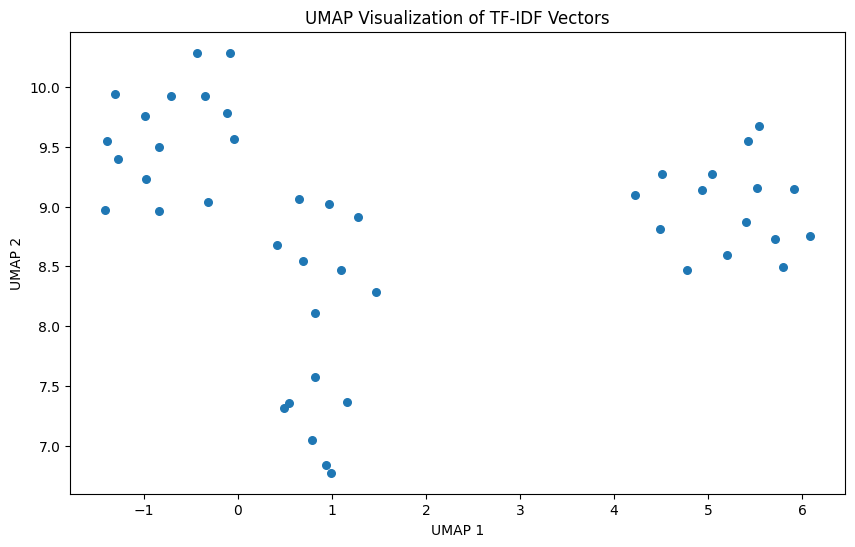

In [68]:
import umap

umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=30)
plt.title("UMAP Visualization of TF-IDF Vectors")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()